# MOPITT CO Retrievals

This script reads in MOPITT data (L3).

User guide: https://www2.acom.ucar.edu/sites/default/files/documents/v9_users_guide_20220203.pdf

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
from datetime import timedelta

# More uncommon imports -- make sure you have satellite_processing_functions.py in the same directory
import netCDF4 as nc
import geopandas as gpd
import shapely

from satellite_processing_functions import convert_to_string

# Mapping functions -- not required to process the data, but nice to plot as a sanity check!
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%config InlineBackend.figure_format='retina'
plt.rcParams["font.family"] = "Arial"

def basemap():
    # Creates a fig and ax object with a map of the globe using the Cartopy library
    fig = plt.figure(figsize=(10,5));
    ax = fig.add_subplot(111, projection=ccrs.Robinson()); # Can change the projection using different ccrs.__()
    color = 'gray' # Color of the map lines

    # Add in the coastlines, states, and country borders with 50 m resolution.
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5, edgecolor = color);
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor = color);
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.5, edgecolor = color);

    return fig, ax;

In [29]:
averaging_kernel = True;

years = np.arange(2020,2021,1).astype(str)
month_num = np.arange(8,9,1)

months = convert_to_string(month_num, 'month');

In [127]:
mopitt_data = np.array([])

for year in years:
    for month in months:
        date = f'{year}-{month}-01'

        files = glob(f"/home/disk/p/jyyoon/hermes/jyyoon/MOPITT/MOP03JM-{year}{month}-L3V95.9.3.he5")
        
        for f in files:
            data = xr.open_dataset(f, group = 'HDFEOS/GRIDS/MOP03/Data Fields')

            if averaging_kernel:
                data = data.rename({'Prs1' : 'Prs2'});
                data = data[['Latitude', 'Longitude', 'RetrievedCOSurfaceMixingRatioDay', 'RetrievedCOTotalColumnDay', 
                             'RetrievedCOTotalColumnVariabilityDay', 'RetrievedCOTotalColumnMeanUncertaintyDay', 
                             'APrioriCOTotalColumnDay', 'APrioriCOSurfaceMixingRatioDay', 'APrioriCOMixingRatioProfileDay',
                             'Pressure', 'Pressure2', 'TotalColumnAveragingKernelDay']]
                data['RetrievedCOSurfaceMixingRatioDay'] = data.RetrievedCOSurfaceMixingRatioDay.where(data.RetrievedCOSurfaceMixingRatioDay > -9999, other = np.nan)
                data['RetrievedCOTotalColumnDay'] = data.RetrievedCOTotalColumnDay.where(data.RetrievedCOTotalColumnDay > -9999, other = np.nan)
                
                data = data.rename({'Latitude' : 'lat', 'Longitude' : 'lon', 'Pressure' : 'p', 'Pressure2' : 'p2'})
                data['time'] = pd.to_datetime(date);
                data = data.swap_dims({'XDim' : 'lon', 'YDim' : 'lat', 'Prs' : 'p', 'Prs2' : 'p2'}).set_coords(['lat', 'lon', 'p', 'p2'])
            
            else:
                data = data[['Latitude', 'Longitude', 'RetrievedCOSurfaceMixingRatioDay', 'RetrievedCOTotalColumnDay', 
                             'RetrievedCOTotalColumnVariabilityDay', 'RetrievedCOTotalColumnMeanUncertaintyDay', 
                             'APrioriCOTotalColumnDay']]

                data['RetrievedCOSurfaceMixingRatioDay'] = data.RetrievedCOSurfaceMixingRatioDay.where(data.RetrievedCOSurfaceMixingRatioDay > -9999, other = np.nan)
                data['RetrievedCOTotalColumnDay'] = data.RetrievedCOTotalColumnDay.where(data.RetrievedCOTotalColumnDay > -9999, other = np.nan)
                
                data = data.rename({'Latitude' : 'lat', 'Longitude' : 'lon'})
                data['time'] = pd.to_datetime(date);
                data = data.to_dataframe().reset_index().set_index(['time', 'lat', 'lon']).to_xarray()

            if len(mopitt_data) == 0:
                mopitt_data = data.copy();
            else:
                mopitt_data = xr.concat([mopitt_data, data], dim = 'time')

## Visualize!

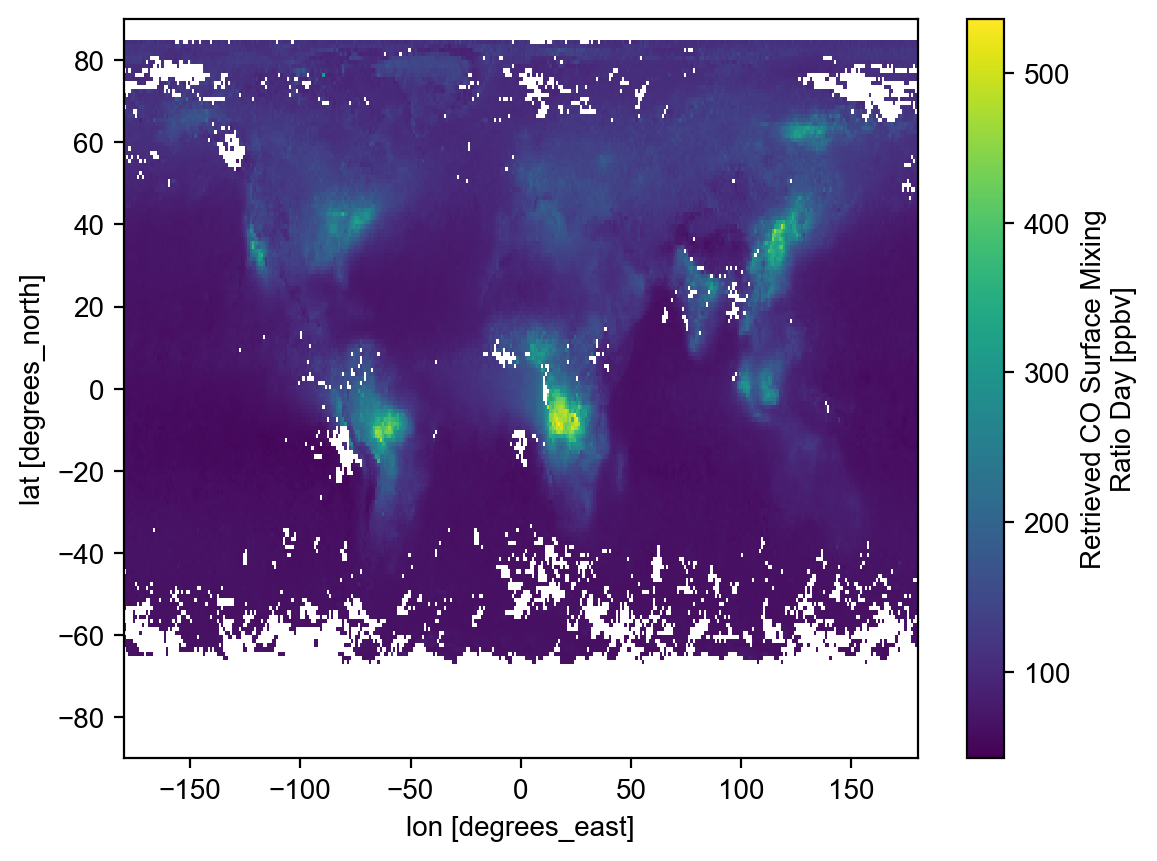

In [132]:
mopitt_data.RetrievedCOSurfaceMixingRatioDay.T.plot()

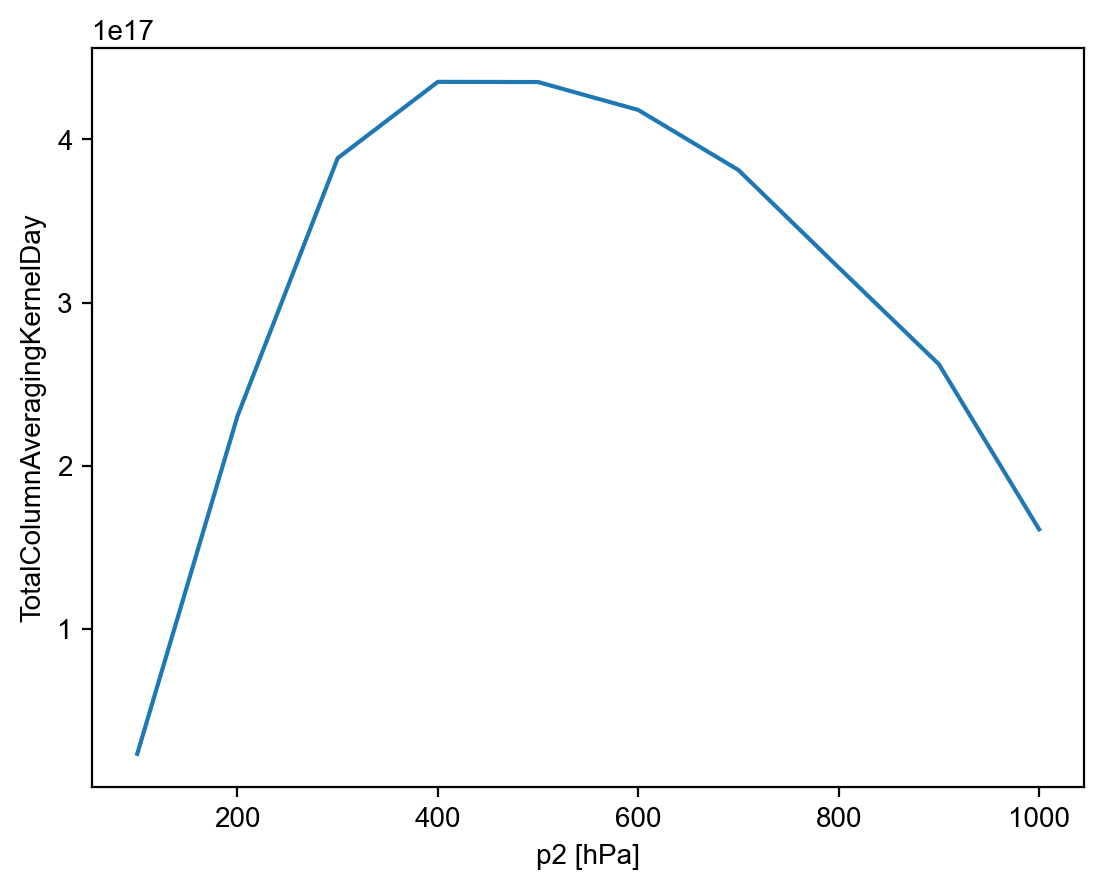

In [130]:
mopitt_data.TotalColumnAveragingKernelDay.mean(['lat', 'lon']).plot(x = 'p2')